# Trying to get learning of angles working, now with probabilities

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

from typing import Optional, Union

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

import flax
from flax.training import train_state

import ciclo
import optax
import distrax

import jax
from jax import lax
import flax
import flax.linen as nn
flax.config.update('flax_use_orbax_checkpointing', True)

from clu import parameter_overview

from typing import Any

from functools import partial

import tensorflow_datasets as tfds

from clu import deterministic_data
from clu import preprocess_spec
from clu import metrics

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.utils.preprocess import all_ops
from src.transformations import transform_image


PRNGKey = Any

2023-09-06 15:44:44.032170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
rng = random.PRNGKey(0)
train_data_rng, val_data_rng, init_rng, state_rng = random.split(rng, 4)

## Get data

In [3]:
ANGLE = 180

config = config_dict.ConfigDict()

config.batch_size = 512
config.dataset = "MNIST"
config.shuffle_buffer_size = 50_000
config.repeat_after_batching = True  # NOTE: ordering of PP, shuffle, and repeat is important!
config.train_split = f"train[10000:]"
config.pp_train = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image"])'
config.val_split = f"train[:10000]"
config.pp_eval = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image", "label"])'


config.model = config_dict.ConfigDict()
config.model.bounds = (0.25, 0.25, jnp.pi, 0.25, 0.25)
config.model.offset = (0.0, 0.0, 0.0, 0.0, 0.0)
config.model.inference = config_dict.ConfigDict()
config.model.inference.hidden_dims = (1024, 512, 256, 128)
config.model.generative = config_dict.ConfigDict()
config.model.generative.hidden_dims = (1024, 512, 256)
config.model.generative.num_flows = 2
config.model.generative.num_bins = 4
config.model.generative.conditioner = config_dict.ConfigDict()
config.model.generative.conditioner.hidden_dims = (128,)


In [4]:
(3 * config.model.generative.num_bins + 1) * len(config.model.bounds)

65

In [5]:
def get_data(config):
    dataset_builder = tfds.builder(config.dataset)
    dataset_builder.download_and_prepare()

    local_batch_size  = config.batch_size // jax.device_count()

    train_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(config.train_split),
        # This RNG key will be used to derive all randomness in shuffling, data
        # preprocessing etc.
        rng=train_data_rng,
        shuffle_buffer_size=config.shuffle_buffer_size,
        # Depending on TPU/other runtime, local device count will be 8/1.
        batch_dims=[jax.local_device_count(), local_batch_size],
        repeat_after_batching=False,
        preprocess_fn=preprocess_spec.parse(
            spec=config.pp_train,
            available_ops=all_ops(),
        ),
        shuffle="loaded",
        )


    num_val_examples = dataset_builder.info.splits[config.val_split].num_examples
    # Compute how many batches we need to contain the entire val set.
    pad_up_to_batches = int(jnp.ceil(num_val_examples / config.batch_size))

    val_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(config.val_split),
        rng=val_data_rng,
        batch_dims=[jax.local_device_count(), local_batch_size],
        num_epochs=1,
        preprocess_fn=preprocess_spec.parse(
            spec=config.pp_eval,
            available_ops=all_ops(),
        ),
        # Pad with masked examples instead of dropping incomplete final batch.
        pad_up_to_batches=pad_up_to_batches,
        shuffle=False)

    return train_ds, val_ds

In [6]:
train_ds, val_ds = get_data(config)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

## Setup TrainState and NN

In [7]:
@flax.struct.dataclass  # <-- required for JAX transformations
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')
    x_mse: metrics.Average.from_output('x_mse')
    log_p_η_x_hat: metrics.Average.from_output('log_p_η_x_hat')
    mae: metrics.Average.from_output('mae')
    

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

class TrainState(train_state.TrainState):
    metrics: Metrics
    rng: PRNGKey
    λ: float
    λ_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    α: float
    α_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    polyak_step_size: Optional[float] = None
    avg_params: Optional[flax.core.FrozenDict] = None

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(grads, self.opt_state, self.params)
        new_params = optax.apply_updates(self.params, updates)

        if self.polyak_step_size is not None:
            new_avg_params = optax.incremental_update(new_params, self.avg_params, self.polyak_step_size)
        else:
            new_avg_params = None

        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            λ=self.λ_schedule(self.step),
            α=self.α_schedule(self.step),
            avg_params=new_avg_params,
            **kwargs,
        )

    @classmethod
    def create(
        cls,
        *,
        apply_fn,
        params,
        tx,
        λ_schedule,
        α_schedule,
        **kwargs,
    ):
        opt_state = tx.init(params)
        if kwargs.get("polyak_step_size", None) is not None:
            avg_params = params
        else:
            avg_params = None
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            λ_schedule=λ_schedule,
            λ=λ_schedule(0),
            α_schedule=α_schedule,
            α=α_schedule(0),
            avg_params=avg_params,
            **kwargs,
        )

def reset_metrics(state):
    return state.replace(metrics=state.metrics.empty())

In [8]:
from typing import Callable, Mapping, Optional, Sequence
from chex import Array, PRNGKey
import numpy as np
from flax.linen import initializers as init

KwArgs = Mapping[str, Any]

INV_SOFTPLUS_1 = jnp.log(jnp.exp(1) - 1.0)


def approximate_mode(
    distribution: distrax.Distribution, num_samples: int, rng: PRNGKey
) -> Array:
    """Approximates the mode of a distribution by taking a number of samples and returning the most likely.

    Args:
        distribution: A distribution.
        num_samples: The number of samples to take.
        rng: A PRNG key.

    Returns:
        An approximate mode.
    """
    samples, log_probs = distribution.sample_and_log_prob(
        seed=rng, sample_shape=(num_samples,)
    )
    return samples[jnp.argmax(log_probs)]


class TransformationInferenceNet(nn.Module):
    event_shape: Sequence[int]
    hidden_dims: Sequence[int]
    bounds_array: Array
    offset_array: Array
    σ_init: Callable = init.constant(jnp.log(jnp.exp(.01) - 1.0))

    @nn.compact
    def __call__(self, x, train: bool = True):
        h = x.flatten()

        for hidden_dim in self.hidden_dims:
            h = nn.Dense(hidden_dim)(h)
            h = nn.relu(h)
    
        output_dim = np.prod(self.event_shape)
        μ = nn.Dense(output_dim)(h)

        # return jax.nn.tanh(μ) * self.bounds_array

        # σ = jax.nn.softplus(nn.Dense(output_dim, name='σ_')(h)) 
        σ = jax.nn.softplus(self.param("σ_", self.σ_init, self.event_shape))

        # sample = distrax.Normal(loc=μ, scale=σ).sample(seed=self.make_rng('sample'))
        # return jax.nn.tanh(sample) * self.bounds_array

        base = distrax.Independent(
            distrax.Normal(loc=μ, scale=σ),
            len(self.event_shape)
        )

        bijector = distrax.Chain([
            distrax.Block(
                distrax.ScalarAffine(
                    shift=self.offset_array, scale=self.bounds_array
                ),
                len(self.event_shape)
            ),
            distrax.Block(distrax.Tanh(), len(self.event_shape)),
        ])
    
        return distrax.Transformed(base, bijector)


class Conditioner(nn.Module):
    """A neural network that predicts the parameters of a flow given an input."""
    event_shape: Sequence[int]
    num_bijector_params: int
    hidden_dims: Sequence[int]
    train: Optional[bool] = None

    @nn.compact
    def __call__(self, x: Array, train: Optional[bool] = None) -> Array:
        train = nn.merge_param("train", self.train, train)

        h = x.flatten()

        for hidden_dim in self.hidden_dims:
            h = nn.Dense(hidden_dim)(h)
            h = nn.relu(h)

        # We initialize this dense layer to zero so that the flow is initialized to the identity function.
        y = nn.Dense(
            np.prod(self.event_shape) * self.num_bijector_params,
            kernel_init=init.zeros,
            bias_init=init.zeros,
        )(h)
        y = y.reshape(tuple(self.event_shape) + (self.num_bijector_params,))

        return y


class TransformationGenerativeNet(nn.Module):
    event_shape: Sequence[int]
    hidden_dims: Sequence[int]
    bounds_array: Array
    offset_array: Array
    num_flows: int
    num_bins: int
    conditioner: Optional[KwArgs] = None
    ε: float = 1e-6

    @nn.compact
    def __call__(self, x_hat, train: bool = True):
        h = x_hat.flatten()

        # shared feature extractor
        for hidden_dim in self.hidden_dims:
            h = nn.Dense(hidden_dim)(h)
            h = nn.relu(h)
    
        # base distribution
        base_hidden = nn.Dense(hidden_dim // 2)(h)

        output_dim = np.prod(self.event_shape)
        μ = nn.Dense(output_dim)(base_hidden)
        σ = jax.nn.softplus(nn.Dense(output_dim, name='σ_')(base_hidden)) 
        base = distrax.Independent(
            distrax.Normal(loc=μ, scale=σ),
            len(self.event_shape)
        )

        # bijector
        # Number of parameters for the rational-quadratic spline:
        # - `num_bins` bin widths
        # - `num_bins` bin heights
        # - `num_bins + 1` knot slopes
        # for a total of `3 * num_bins + 1` parameters.
        num_bijector_params = 3 * self.num_bins + 1

        layers = []
        for _ in range(self.num_flows):
            params = Conditioner(
                event_shape=self.event_shape,
                num_bijector_params=num_bijector_params,
                train=train,
                **(self.conditioner or {}),
            )(h)
            layer = distrax.Block(
                distrax.RationalQuadraticSpline(params, range_min=-5.0, range_max=5.0),
                # TODO: do these ranges matter? Maybe it just needs to be -1 to 1 to match the output of the tanh,
                # rather than the input to the tanh. Do some tests.
                len(self.event_shape),
            )
            layers.append(layer)

        bijector = distrax.Chain([
            distrax.Block(
                distrax.ScalarAffine(
                    shift=self.offset_array, scale=self.bounds_array + self.ε
                ),
                len(self.event_shape)
            ),
            distrax.Block(distrax.Tanh(), len(self.event_shape)),
            # We invert the flow so that the `forward` method is called with `log_prob`.
            distrax.Inverse(distrax.Chain(layers)),
        ])
    
        return distrax.Transformed(base, bijector)
    
    
class PrototypicalGenerativeModel(nn.Module):
    bounds: Sequence[int]
    offset: Optional[Sequence[int]] = None
    inference: Optional[KwArgs] = None
    generative: Optional[KwArgs] = None

    def setup(self) -> None:
        self.bounds_array = jnp.array(self.bounds)
        self.offset_array = (
            jnp.array(self.offset)
            if self.offset is not None
            else jnp.zeros_like(self.bounds_array)
        )
        self.event_shape = self.bounds_array.shape
        self.inference_net = TransformationInferenceNet(
            event_shape=self.event_shape,
            bounds_array=self.bounds_array,
            offset_array=self.offset_array,
            **(self.inference or {}),
        )
        self.generative_net = TransformationGenerativeNet(
            event_shape=self.event_shape,
            bounds_array=self.bounds_array,
            offset_array=self.offset_array,
            **(self.generative or {}),
        )

    
    def __call__(self, x, train: bool = True):
        q_H_x = self.inference_net(x, train=train)
        η = q_H_x.sample(seed=self.make_rng('sample'))

        x_hat = transform_image(x, -η)

        p_H_x_hat = self.generative_net(x_hat, train=train)
        log_p_η_x_hat = p_H_x_hat.log_prob(η)

        return η, log_p_η_x_hat
    
    def generative_net_ll(self, x_hat, η, train: bool = True):
        p_H_x_hat = self.generative_net(x_hat, train=train)
        return p_H_x_hat.log_prob(η)

In [9]:
# model.apply(variables, jnp.ones((28, 28, 1)), train=False, rngs={"sample": random.PRNGKey(0)})

In [10]:
model = PrototypicalGenerativeModel(**config.model.to_dict())

variables = model.init({'params': init_rng, 'sample': init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+----------------------------------------------------+-------------+---------+-----------+--------+
| Name                                               | Shape       | Size    | Mean      | Std    |
+----------------------------------------------------+-------------+---------+-----------+--------+
| params/generative_net/Conditioner_0/Dense_0/bias   | (128,)      | 128     | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_0/kernel | (256, 128)  | 32,768  | -0.000902 | 0.0624 |
| params/generative_net/Conditioner_0/Dense_1/bias   | (65,)       | 65      | 0.0       | 0.0    |
| params/generative_net/Conditioner_0/Dense_1/kernel | (128, 65)   | 8,320   | 0.0       | 0.0    |
| params/generative_net/Conditioner_1/Dense_0/bias   | (128,)      | 128     | 0.0       | 0.0    |
| params/generative_net/Conditioner_1/Dense_0/kernel | (256, 128)  | 32,768  | -0.000483 | 0.0626 |
| params/generative_net/Conditioner_1/Dense_1/bias   | (65,)       | 65      | 0.0       

In [11]:
TOTAL_STEPS = 10_000
LR = 1e-4
N_SAMPLES = 5
POLYAK_STEP_SIZE = None

params = flax.core.freeze(variables["params"])

def lr_schedule(init_lr, peak_mult, final_mult, peak_steps, total_steps=TOTAL_STEPS): 
    return optax.warmup_cosine_decay_schedule(
        init_lr, init_lr*peak_mult, peak_steps, total_steps, end_value=init_lr*final_mult
    )

def clipped_adamw(learning_rate, norm):
    return optax.MultiSteps(optax.chain(
        optax.clip_by_global_norm(norm),
        optax.adamw(learning_rate=learning_rate)
    ), 1)


from flax import traverse_util
# partition_optimizers = {
#     "inference": optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
#     "σ": optax.inject_hyperparams(optax.adam)(lr_schedule(LR * 100, 3, 1/3, TOTAL_STEPS//10)),
#     # "generative": optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
#     "generative": optax.inject_hyperparams(clipped_adamw)(
#         optax.join_schedules([
#             optax.constant_schedule(0.),
#             optax.linear_schedule(LR, LR*3, TOTAL_STEPS * 3 // 40),
#             optax.cosine_decay_schedule(LR*3, TOTAL_STEPS * 27 // 40, (LR / 30) / (LR*3)),
#         ], [TOTAL_STEPS//4, TOTAL_STEPS//4 + TOTAL_STEPS * 3 // 40]),
#         2.
#     ),
# }

partition_optimizers = {
    "inference": optax.inject_hyperparams(clipped_adamw)(
        optax.join_schedules([
            lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10),
            optax.constant_schedule(0.),
        ], [TOTAL_STEPS,]),
        2.
    ),
    "σ": optax.inject_hyperparams(optax.adam)(
        optax.join_schedules([
            lr_schedule(LR * 100, 3, 1/3, TOTAL_STEPS//10),
            optax.constant_schedule(0.),
        ], [TOTAL_STEPS,])
    ),
    "generative": optax.inject_hyperparams(clipped_adamw)(
        optax.join_schedules([
            optax.constant_schedule(0.),
            lr_schedule(LR * 3, 9, 1/300, TOTAL_STEPS//10, total_steps=TOTAL_STEPS),
        ], [TOTAL_STEPS,]),
        2.
    ),
}

def get_partition(path, value):
    if "generative_net" in path:
        return "generative"
    
    if "inference_net" in path:
        if "σ_" in path:
            return "σ"
        
        return "inference"

param_partitions = flax.core.freeze(traverse_util.path_aware_map(get_partition, params))
opt = optax.multi_transform(partition_optimizers, param_partitions)


state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    # tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),
    tx=opt,
    metrics=Metrics.empty(),
    rng=state_rng,
    # λ_schedule=optax.cosine_decay_schedule(1., TOTAL_STEPS, 1.),
    # λ_schedule=optax.linear_schedule(0., 1., TOTAL_STEPS, TOTAL_STEPS//2),
    λ_schedule=optax.join_schedules([
        optax.constant_schedule(0.),
        optax.constant_schedule(1.),
    ], [TOTAL_STEPS,]),
    α_schedule=optax.join_schedules([
        optax.constant_schedule(1.),
        optax.cosine_decay_schedule(1., TOTAL_STEPS // 4, 0.0),
    ], [TOTAL_STEPS,]),
    polyak_step_size=POLYAK_STEP_SIZE,
)

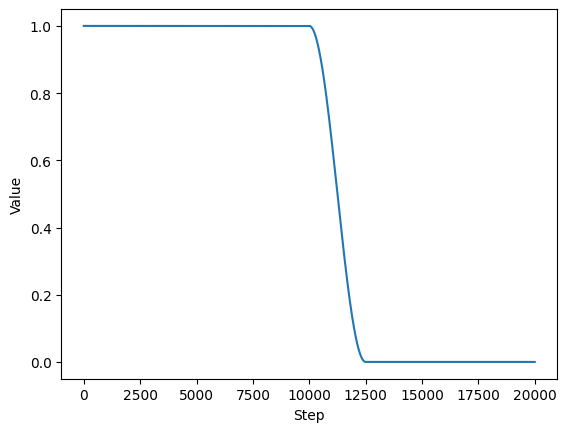

In [12]:
# helper function to plot an optax LR shedule
def plot_lr_schedule(lr_schedule, total_steps=TOTAL_STEPS * 2 + 1):
    steps = np.arange(total_steps)
    lrs = [lr_schedule(step) for step in steps]
    plt.plot(steps, lrs)
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()

plot_lr_schedule(state.α_schedule)

In [13]:
def loss_fn(
    x, params, state, step_rng, train, n_samples,
):
    """Self-supervised loss function. 
    
    The loss can be summarised with the following diagram

            x ------- -η_x -----> x_hat
            |                       |
            |                       v
         η_rand                    mse
            |                       ∧
            ∨                       |
         x_rand --- -η_x_rand ---> x_hat'.

    However, implementing this directly requires doing 3 affine transformations, which adds 'blur' to the image.
    So instead we note that the diagram above is equivalent to

            x --------> mse <------- x'
            |                        ∧
            |                        |
         η_rand                     η_x
            |                        |
            v                        |
         x_rand --- -η_x_rand ---> x_hat'.

    Finally, this computation can be simplified to

            x --------> mse <-------- x'
            |                         ∧
            └ η_rand - η_x_rand + η_x ┘

    which contains only a single transformation.

    """
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    
    def per_sample_loss(rng):
        rng_sample1, rng_sample2, rng_η_rand, = random.split(rng, 3)

        η_x, _ = state.apply_fn(
            {"params": params}, x, train, rngs={"sample": rng_sample1}
        )

        Η_rand = distrax.Uniform(
            low=-jnp.array(config.model.bounds) + jnp.array(config.model.offset),
            high=jnp.array(config.model.bounds) + jnp.array(config.model.offset)
        )
        η_rand = Η_rand.sample(seed=rng_η_rand, sample_shape=())

        x_rand = transform_image(x, η_rand)
        η_x_rand, _ = state.apply_fn(
            {"params": params}, x_rand, train, rngs={"sample": rng_sample2}
        )

        x_mse = optax.squared_error(x, transform_image(x, η_rand - η_x_rand + η_x)).mean()

        difficulty = optax.squared_error(x, x_rand).mean()

        log_p_η_x_hat = model.apply(
            {"params": params},
            jax.lax.stop_gradient(transform_image(x, η_rand - η_x_rand)),
            jax.lax.stop_gradient(η_x), train=train,
            method=model.generative_net_ll
        )
        # log_p_η_x_hat = model.apply(
        #     {"params": params},
        #     jax.lax.stop_gradient(transform_image(x, -η_x)),
        #     jax.lax.stop_gradient(η_x), train=train,
        #     method=model.generative_net_ll
        # )

        return x_mse, difficulty, log_p_η_x_hat
    
    rngs = random.split(rng_local, n_samples)
    x_mse, difficulty, log_p_η_x_hat = jax.vmap(per_sample_loss)(rngs)
    
    # do a weighted average based on the difficulty of the sample
    weights = difficulty / difficulty.sum()
    x_mse, = jax.tree_map(lambda x: (x * weights).sum(axis=0), (x_mse,))
    
    pairwise_diffs = jax.vmap(jax.vmap(lambda x, y: x - y, in_axes=(0, None)), in_axes=(None, 0))(log_p_η_x_hat, log_p_η_x_hat)
    mae = jnp.abs(pairwise_diffs).mean()

    log_p_η_x_hat = log_p_η_x_hat.mean(axis=0)

    loss = x_mse - log_p_η_x_hat * state.λ + mae * (1 - state.α)

    return loss, {"loss": loss, "x_mse": x_mse, "log_p_η_x_hat": log_p_η_x_hat, "mae": mae}

In [14]:
foo = jnp.arange(4)
bar = foo/10

pairwise_diffs = jax.vmap(jax.vmap(lambda x, y: x - y, in_axes=(0, None)), in_axes=(None, 0))(bar, bar)

jnp.abs(pairwise_diffs).mean()

Array(0.125, dtype=float32)

In [15]:
@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, True, N_SAMPLES,
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, metrics

    (_, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        **metrics
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())
    logs.add_entry("schedules", "λ", state.λ)
    logs.add_entry("schedules", "α", state.α)
    # logs.add_entry("schedules", "lr", state.opt_state.hyperparams["learning_rate"])
    logs.add_entry("schedules", "lr_inference", state.opt_state.inner_states['inference'][0].hyperparams["learning_rate"])
    logs.add_entry("schedules", "lr_generative", state.opt_state.inner_states['generative'][0].hyperparams["learning_rate"])
    logs.add_entry("schedules", "lr_σ", state.opt_state.inner_states['σ'][0].hyperparams["learning_rate"])
    logs.add_entry("gradients", "grad_norm", optax.global_norm(grads))
    reduce_grads = lambda tree: jax.tree_util.tree_reduce(lambda x, y: jnp.abs(y).sum() + x, tree, 0)
    logs.add_entry("gradients", "gen_sum", reduce_grads(grads['generative_net']))
    logs.add_entry("gradients", "inf_sum", reduce_grads(grads['inference_net']))

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, False, 1
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, metrics

    # _, metrics = batch_loss_fn(state.params)
    _, metrics = batch_loss_fn(state.params if state.avg_params is None else state.avg_params)

    metrics = state.metrics.update(
        **metrics, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [16]:
final_state, history, _ = ciclo.train_loop(
    state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS * 2),
        # ciclo.early_stopping("loss_test", patience=TOTAL_STEPS // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=TOTAL_STEPS * 2 + 1,
)

INFO:absl:Saving checkpoint at step: -0.45687893
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.4568789303302765.
INFO:absl:Renaming checkpoint/checkpoint_-0.4568789303302765.orbax-checkpoint-tmp-1694011552238661 to checkpoint/checkpoint_-0.4568789303302765
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.4568789303302765`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_5.005930423736572


   97/30000 [..............................] - ETA: 1:58:49 - log_p_η_x_hat: 0.0127 - loss: 0.3830 - mae: 0.6064 - x_mse: 0.3830 - log_p_η_x_hat_test: 0.4003 - loss_test: 0.4569 - mae_test: 0.0000e+00 - x_mse_test: 0.4569

INFO:absl:Saving checkpoint at step: -0.34122372
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.34122371673583984.
INFO:absl:Renaming checkpoint/checkpoint_-0.34122371673583984.orbax-checkpoint-tmp-1694011555330594 to checkpoint/checkpoint_-0.34122371673583984
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.34122371673583984`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.4568789303302765


  199/30000 [..............................] - ETA: 1:04:26 - log_p_η_x_hat: -1.0152 - loss: 0.3288 - mae: 0.7988 - x_mse: 0.3288 - log_p_η_x_hat_test: -1.0263 - loss_test: 0.3412 - mae_test: 0.0000e+00 - x_mse_test: 0.3412

INFO:absl:Saving checkpoint at step: -0.30934626
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.3093462586402893.
INFO:absl:Renaming checkpoint/checkpoint_-0.3093462586402893.orbax-checkpoint-tmp-1694011557989152 to checkpoint/checkpoint_-0.3093462586402893
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.3093462586402893`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.34122371673583984


  298/30000 [..............................] - ETA: 47:16 - log_p_η_x_hat: -0.7795 - loss: 0.3108 - mae: 0.7204 - x_mse: 0.3108 - log_p_η_x_hat_test: -0.9568 - loss_test: 0.3093 - mae_test: 0.0000e+00 - x_mse_test: 0.3093

INFO:absl:Saving checkpoint at step: -0.29700986
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2970098555088043.
INFO:absl:Renaming checkpoint/checkpoint_-0.2970098555088043.orbax-checkpoint-tmp-1694011560659555 to checkpoint/checkpoint_-0.2970098555088043
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2970098555088043`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.3093462586402893


  499/30000 [..............................] - ETA: 33:01 - log_p_η_x_hat: -0.7300 - loss: 0.2960 - mae: 0.6970 - x_mse: 0.2960 - log_p_η_x_hat_test: -0.6810 - loss_test: 0.2990 - mae_test: 0.0000e+00 - x_mse_test: 0.2990

INFO:absl:Saving checkpoint at step: -0.29081348
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.29081347584724426.
INFO:absl:Renaming checkpoint/checkpoint_-0.29081347584724426.orbax-checkpoint-tmp-1694011565697845 to checkpoint/checkpoint_-0.29081347584724426
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.29081347584724426`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2970098555088043


  597/30000 [..............................] - ETA: 29:57 - log_p_η_x_hat: -0.6709 - loss: 0.2935 - mae: 0.6836 - x_mse: 0.2935 - log_p_η_x_hat_test: -0.6231 - loss_test: 0.2908 - mae_test: 0.0000e+00 - x_mse_test: 0.2908

INFO:absl:Saving checkpoint at step: -0.2844209
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.284420907497406.
INFO:absl:Renaming checkpoint/checkpoint_-0.284420907497406.orbax-checkpoint-tmp-1694011568698972 to checkpoint/checkpoint_-0.284420907497406
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.284420907497406`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.29081347584724426


  798/30000 [..............................] - ETA: 25:17 - log_p_η_x_hat: -0.4026 - loss: 0.2884 - mae: 0.6157 - x_mse: 0.2884 - log_p_η_x_hat_test: -0.3075 - loss_test: 0.2856 - mae_test: 0.0000e+00 - x_mse_test: 0.2856

INFO:absl:Saving checkpoint at step: -0.2788691
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.278869092464447.
INFO:absl:Renaming checkpoint/checkpoint_-0.278869092464447.orbax-checkpoint-tmp-1694011573665454 to checkpoint/checkpoint_-0.278869092464447
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.278869092464447`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.284420907497406


  899/30000 [..............................] - ETA: 23:48 - log_p_η_x_hat: -0.4565 - loss: 0.2860 - mae: 0.6262 - x_mse: 0.2860 - log_p_η_x_hat_test: -0.3872 - loss_test: 0.2789 - mae_test: 0.0000e+00 - x_mse_test: 0.2789

INFO:absl:Saving checkpoint at step: -0.27737468
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2773746848106384.
INFO:absl:Renaming checkpoint/checkpoint_-0.2773746848106384.orbax-checkpoint-tmp-1694011576312310 to checkpoint/checkpoint_-0.2773746848106384
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2773746848106384`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.278869092464447


 1199/30000 [>.............................] - ETA: 20:35 - log_p_η_x_hat: -0.5068 - loss: 0.2811 - mae: 0.6306 - x_mse: 0.2811 - log_p_η_x_hat_test: -0.4992 - loss_test: 0.2817 - mae_test: 0.0000e+00 - x_mse_test: 0.2817

INFO:absl:Saving checkpoint at step: -0.27272233
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2727223336696625.
INFO:absl:Renaming checkpoint/checkpoint_-0.2727223336696625.orbax-checkpoint-tmp-1694011583592076 to checkpoint/checkpoint_-0.2727223336696625
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2727223336696625`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2773746848106384


 1898/30000 [>.............................] - ETA: 16:46 - log_p_η_x_hat: -0.3021 - loss: 0.2753 - mae: 0.5779 - x_mse: 0.2753 - log_p_η_x_hat_test: -0.1499 - loss_test: 0.2781 - mae_test: 0.0000e+00 - x_mse_test: 0.2781

INFO:absl:Saving checkpoint at step: -0.27144483
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.27144482731819153.
INFO:absl:Renaming checkpoint/checkpoint_-0.27144482731819153.orbax-checkpoint-tmp-1694011600191207 to checkpoint/checkpoint_-0.27144482731819153
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.27144482731819153`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2727223336696625


 1997/30000 [>.............................] - ETA: 16:30 - log_p_η_x_hat: -0.1714 - loss: 0.2724 - mae: 0.5494 - x_mse: 0.2724 - log_p_η_x_hat_test: -0.1847 - loss_test: 0.2714 - mae_test: 0.0000e+00 - x_mse_test: 0.2714

INFO:absl:Saving checkpoint at step: -0.26135856
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2613585591316223.
INFO:absl:Renaming checkpoint/checkpoint_-0.2613585591316223.orbax-checkpoint-tmp-1694011602820646 to checkpoint/checkpoint_-0.2613585591316223
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2613585591316223`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.27144482731819153


 2799/30000 [=>............................] - ETA: 14:30 - log_p_η_x_hat: -0.1036 - loss: 0.2660 - mae: 0.5895 - x_mse: 0.2660 - log_p_η_x_hat_test: 0.0422 - loss_test: 0.2619 - mae_test: 0.0000e+00 - x_mse_test: 0.2619

INFO:absl:Saving checkpoint at step: -0.26041535
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.26041534543037415.
INFO:absl:Renaming checkpoint/checkpoint_-0.26041534543037415.orbax-checkpoint-tmp-1694011621735472 to checkpoint/checkpoint_-0.26041534543037415
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.26041534543037415`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2613585591316223


 2899/30000 [=>............................] - ETA: 14:22 - log_p_η_x_hat: 0.1918 - loss: 0.2593 - mae: 0.5252 - x_mse: 0.2593 - log_p_η_x_hat_test: -0.1655 - loss_test: 0.2604 - mae_test: 0.0000e+00 - x_mse_test: 0.2604

INFO:absl:Saving checkpoint at step: -0.25763103
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2576310336589813.
INFO:absl:Renaming checkpoint/checkpoint_-0.2576310336589813.orbax-checkpoint-tmp-1694011624397943 to checkpoint/checkpoint_-0.2576310336589813
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2576310336589813`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.26041534543037415


 2999/30000 [=>............................] - ETA: 14:14 - log_p_η_x_hat: 0.5120 - loss: 0.2577 - mae: 0.4639 - x_mse: 0.2577 - log_p_η_x_hat_test: 0.5411 - loss_test: 0.2576 - mae_test: 0.0000e+00 - x_mse_test: 0.2576

INFO:absl:Saving checkpoint at step: -0.25140348
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.25140348076820374.
INFO:absl:Renaming checkpoint/checkpoint_-0.25140348076820374.orbax-checkpoint-tmp-1694011627039869 to checkpoint/checkpoint_-0.25140348076820374
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.25140348076820374`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2576310336589813


 3098/30000 [==>...........................] - ETA: 14:06 - log_p_η_x_hat: 0.3256 - loss: 0.2502 - mae: 0.5033 - x_mse: 0.2502 - log_p_η_x_hat_test: 0.1642 - loss_test: 0.2514 - mae_test: 0.0000e+00 - x_mse_test: 0.2514

INFO:absl:Saving checkpoint at step: -0.24470992
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.24470992386341095.
INFO:absl:Renaming checkpoint/checkpoint_-0.24470992386341095.orbax-checkpoint-tmp-1694011629634413 to checkpoint/checkpoint_-0.24470992386341095
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.24470992386341095`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.25140348076820374


 3399/30000 [==>...........................] - ETA: 13:40 - log_p_η_x_hat: -0.0658 - loss: 0.2458 - mae: 0.5846 - x_mse: 0.2458 - log_p_η_x_hat_test: 0.4078 - loss_test: 0.2495 - mae_test: 0.0000e+00 - x_mse_test: 0.2495

INFO:absl:Saving checkpoint at step: -0.23962168
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.23962168395519257.
INFO:absl:Renaming checkpoint/checkpoint_-0.23962168395519257.orbax-checkpoint-tmp-1694011636990319 to checkpoint/checkpoint_-0.23962168395519257
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.23962168395519257`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.24470992386341095


 3498/30000 [==>...........................] - ETA: 13:33 - log_p_η_x_hat: 0.2100 - loss: 0.2407 - mae: 0.5378 - x_mse: 0.2407 - log_p_η_x_hat_test: 0.2818 - loss_test: 0.2396 - mae_test: 0.0000e+00 - x_mse_test: 0.2396

INFO:absl:Saving checkpoint at step: -0.23356432
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2335643172264099.
INFO:absl:Renaming checkpoint/checkpoint_-0.2335643172264099.orbax-checkpoint-tmp-1694011639622653 to checkpoint/checkpoint_-0.2335643172264099
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2335643172264099`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.23962168395519257


 3998/30000 [==>...........................] - ETA: 12:56 - log_p_η_x_hat: 0.1349 - loss: 0.2316 - mae: 0.5433 - x_mse: 0.2316 - log_p_η_x_hat_test: -0.2866 - loss_test: 0.2368 - mae_test: 0.0000e+00 - x_mse_test: 0.2368

INFO:absl:Saving checkpoint at step: -0.22814049
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.22814048826694489.
INFO:absl:Renaming checkpoint/checkpoint_-0.22814048826694489.orbax-checkpoint-tmp-1694011651561253 to checkpoint/checkpoint_-0.22814048826694489
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.22814048826694489`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2335643172264099


 4097/30000 [===>..........................] - ETA: 12:51 - log_p_η_x_hat: 0.3960 - loss: 0.2358 - mae: 0.5061 - x_mse: 0.2358 - log_p_η_x_hat_test: 0.0712 - loss_test: 0.2281 - mae_test: 0.0000e+00 - x_mse_test: 0.2281

INFO:absl:Saving checkpoint at step: -0.22806805
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2280680537223816.
INFO:absl:Renaming checkpoint/checkpoint_-0.2280680537223816.orbax-checkpoint-tmp-1694011654198516 to checkpoint/checkpoint_-0.2280680537223816
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2280680537223816`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.22814048826694489


 4198/30000 [===>..........................] - ETA: 12:46 - log_p_η_x_hat: 0.1821 - loss: 0.2269 - mae: 0.5346 - x_mse: 0.2269 - log_p_η_x_hat_test: -0.2211 - loss_test: 0.2281 - mae_test: 0.0000e+00 - x_mse_test: 0.2281

INFO:absl:Saving checkpoint at step: -0.22394225
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.22394225001335144.
INFO:absl:Renaming checkpoint/checkpoint_-0.22394225001335144.orbax-checkpoint-tmp-1694011656845431 to checkpoint/checkpoint_-0.22394225001335144
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.22394225001335144`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2280680537223816


 4399/30000 [===>..........................] - ETA: 12:34 - log_p_η_x_hat: -0.0822 - loss: 0.2262 - mae: 0.5768 - x_mse: 0.2262 - log_p_η_x_hat_test: -0.4019 - loss_test: 0.2282 - mae_test: 0.0000e+00 - x_mse_test: 0.2282

INFO:absl:Saving checkpoint at step: -0.22319837
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.22319836914539337.
INFO:absl:Renaming checkpoint/checkpoint_-0.22319836914539337.orbax-checkpoint-tmp-1694011661804387 to checkpoint/checkpoint_-0.22319836914539337
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.22319836914539337`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.22394225001335144


 4598/30000 [===>..........................] - ETA: 12:23 - log_p_η_x_hat: -0.1722 - loss: 0.2248 - mae: 0.6187 - x_mse: 0.2248 - log_p_η_x_hat_test: 0.0185 - loss_test: 0.2244 - mae_test: 0.0000e+00 - x_mse_test: 0.2244

INFO:absl:Saving checkpoint at step: -0.21994954
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.21994954347610474.
INFO:absl:Renaming checkpoint/checkpoint_-0.21994954347610474.orbax-checkpoint-tmp-1694011666788632 to checkpoint/checkpoint_-0.21994954347610474
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.21994954347610474`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.22319836914539337


 4698/30000 [===>..........................] - ETA: 12:19 - log_p_η_x_hat: 0.0760 - loss: 0.2253 - mae: 0.5607 - x_mse: 0.2253 - log_p_η_x_hat_test: -0.0488 - loss_test: 0.2199 - mae_test: 0.0000e+00 - x_mse_test: 0.2199

INFO:absl:Saving checkpoint at step: -0.21777213
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.21777212619781494.
INFO:absl:Renaming checkpoint/checkpoint_-0.21777212619781494.orbax-checkpoint-tmp-1694011669453740 to checkpoint/checkpoint_-0.21777212619781494
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.21777212619781494`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.21994954347610474


 5098/30000 [====>.........................] - ETA: 11:57 - log_p_η_x_hat: 0.1258 - loss: 0.2180 - mae: 0.5494 - x_mse: 0.2180 - log_p_η_x_hat_test: -0.0565 - loss_test: 0.2206 - mae_test: 0.0000e+00 - x_mse_test: 0.2206

INFO:absl:Saving checkpoint at step: -0.2140044
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.21400439739227295.
INFO:absl:Renaming checkpoint/checkpoint_-0.21400439739227295.orbax-checkpoint-tmp-1694011679112203 to checkpoint/checkpoint_-0.21400439739227295
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.21400439739227295`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.21777212619781494


 5598/30000 [====>.........................] - ETA: 11:32 - log_p_η_x_hat: -0.0868 - loss: 0.2157 - mae: 0.6063 - x_mse: 0.2157 - log_p_η_x_hat_test: 0.0139 - loss_test: 0.2175 - mae_test: 0.0000e+00 - x_mse_test: 0.2175

INFO:absl:Saving checkpoint at step: -0.20982532
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2098253220319748.
INFO:absl:Renaming checkpoint/checkpoint_-0.2098253220319748.orbax-checkpoint-tmp-1694011691111721 to checkpoint/checkpoint_-0.2098253220319748
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2098253220319748`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.21400439739227295


 6099/30000 [=====>........................] - ETA: 11:09 - log_p_η_x_hat: -0.0671 - loss: 0.2106 - mae: 0.5841 - x_mse: 0.2106 - log_p_η_x_hat_test: -0.1304 - loss_test: 0.2102 - mae_test: 0.0000e+00 - x_mse_test: 0.2102

INFO:absl:Saving checkpoint at step: -0.20898448
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.20898447930812836.
INFO:absl:Renaming checkpoint/checkpoint_-0.20898447930812836.orbax-checkpoint-tmp-1694011703068492 to checkpoint/checkpoint_-0.20898447930812836
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.20898447930812836`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2098253220319748


 6199/30000 [=====>........................] - ETA: 11:06 - log_p_η_x_hat: 0.0192 - loss: 0.2089 - mae: 0.5681 - x_mse: 0.2089 - log_p_η_x_hat_test: 0.1011 - loss_test: 0.2090 - mae_test: 0.0000e+00 - x_mse_test: 0.2090

INFO:absl:Saving checkpoint at step: -0.20767917
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.2076791673898697.
INFO:absl:Renaming checkpoint/checkpoint_-0.2076791673898697.orbax-checkpoint-tmp-1694011705733945 to checkpoint/checkpoint_-0.2076791673898697
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.2076791673898697`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.20898447930812836


 6399/30000 [=====>........................] - ETA: 10:58 - log_p_η_x_hat: 0.0343 - loss: 0.2078 - mae: 0.5484 - x_mse: 0.2078 - log_p_η_x_hat_test: 0.2877 - loss_test: 0.2097 - mae_test: 0.0000e+00 - x_mse_test: 0.2097

INFO:absl:Saving checkpoint at step: -0.2046186
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.20461860299110413.
INFO:absl:Renaming checkpoint/checkpoint_-0.20461860299110413.orbax-checkpoint-tmp-1694011710699076 to checkpoint/checkpoint_-0.20461860299110413
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.20461860299110413`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.2076791673898697


 6599/30000 [=====>........................] - ETA: 10:50 - log_p_η_x_hat: 0.0315 - loss: 0.2078 - mae: 0.5595 - x_mse: 0.2078 - log_p_η_x_hat_test: 0.2091 - loss_test: 0.2050 - mae_test: 0.0000e+00 - x_mse_test: 0.2050

INFO:absl:Saving checkpoint at step: -0.20441774
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.20441773533821106.
INFO:absl:Renaming checkpoint/checkpoint_-0.20441773533821106.orbax-checkpoint-tmp-1694011715666374 to checkpoint/checkpoint_-0.20441773533821106
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.20441773533821106`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.20461860299110413


 6998/30000 [=====>........................] - ETA: 10:34 - log_p_η_x_hat: 0.0431 - loss: 0.2049 - mae: 0.5463 - x_mse: 0.2049 - log_p_η_x_hat_test: -0.0071 - loss_test: 0.2049 - mae_test: 0.0000e+00 - x_mse_test: 0.2049

INFO:absl:Saving checkpoint at step: -0.19923416
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19923415780067444.
INFO:absl:Renaming checkpoint/checkpoint_-0.19923415780067444.orbax-checkpoint-tmp-1694011725365497 to checkpoint/checkpoint_-0.19923415780067444
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19923415780067444`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.20441773533821106


 7398/30000 [======>.......................] - ETA: 10:19 - log_p_η_x_hat: 0.0061 - loss: 0.2033 - mae: 0.5518 - x_mse: 0.2033 - log_p_η_x_hat_test: 0.1798 - loss_test: 0.2001 - mae_test: 0.0000e+00 - x_mse_test: 0.2001- ETA: 10:20 - log_p_η_x_hat: 0.0221 - loss: 0.2030 - mae: 0.5492 - x_mse: 0.2030 - log_p_η_x_hat_test: 0.1798 - loss_test: 0.2001 - mae_test: 0.0000e+00 - x_mse_test: 0.

INFO:absl:Saving checkpoint at step: -0.19721726
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19721725583076477.
INFO:absl:Renaming checkpoint/checkpoint_-0.19721725583076477.orbax-checkpoint-tmp-1694011735089854 to checkpoint/checkpoint_-0.19721725583076477
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19721725583076477`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19923415780067444


 8399/30000 [=======>......................] - ETA: 9:42 - log_p_η_x_hat: 0.0403 - loss: 0.1993 - mae: 0.5403 - x_mse: 0.1993 - log_p_η_x_hat_test: 0.0307 - loss_test: 0.1990 - mae_test: 0.0000e+00 - x_mse_test: 0.1990

INFO:absl:Saving checkpoint at step: -0.19692248
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19692248106002808.
INFO:absl:Renaming checkpoint/checkpoint_-0.19692248106002808.orbax-checkpoint-tmp-1694011758649394 to checkpoint/checkpoint_-0.19692248106002808
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19692248106002808`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19721725583076477


 8799/30000 [=======>......................] - ETA: 9:28 - log_p_η_x_hat: 0.0125 - loss: 0.1983 - mae: 0.5459 - x_mse: 0.1983 - log_p_η_x_hat_test: 0.0142 - loss_test: 0.1991 - mae_test: 0.0000e+00 - x_mse_test: 0.1991

INFO:absl:Saving checkpoint at step: -0.1948769
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.19487689435482025.
INFO:absl:Renaming checkpoint/checkpoint_-0.19487689435482025.orbax-checkpoint-tmp-1694011768259483 to checkpoint/checkpoint_-0.19487689435482025
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.19487689435482025`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19692248106002808


 9999/30000 [========>.....................] - ETA: 8:48 - log_p_η_x_hat: 0.0701 - loss: 0.1972 - mae: 0.5320 - x_mse: 0.1972 - log_p_η_x_hat_test: 0.0195 - loss_test: 0.1966 - mae_test: 0.0000e+00 - x_mse_test: 0.1966

INFO:absl:Saving checkpoint at step: -0.18697338
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_-0.18697337806224823.
INFO:absl:Renaming checkpoint/checkpoint_-0.18697337806224823.orbax-checkpoint-tmp-1694011796407127 to checkpoint/checkpoint_-0.18697337806224823
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_-0.18697337806224823`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.19487689435482025


10099/30000 [=========>....................] - ETA: 8:45 - log_p_η_x_hat: 2.4261 - loss: -2.2280 - mae: 0.5878 - x_mse: 0.1972 - log_p_η_x_hat_test: 0.0129 - loss_test: 0.1870 - mae_test: 0.0000e+00 - x_mse_test: 0.1999

INFO:absl:Saving checkpoint at step: 4.0698175
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.069817543029785.
INFO:absl:Renaming checkpoint/checkpoint_4.069817543029785.orbax-checkpoint-tmp-1694011799056074 to checkpoint/checkpoint_4.069817543029785
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.069817543029785`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_-0.18697337806224823


10197/30000 [=========>....................] - ETA: 8:43 - log_p_η_x_hat: 4.3494 - loss: -4.1458 - mae: 0.7656 - x_mse: 0.1967 - log_p_η_x_hat_test: 4.2671 - loss_test: -4.0698 - mae_test: 0.0000e+00 - x_mse_test: 0.1973

INFO:absl:Saving checkpoint at step: 4.2234325
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.223432540893555.
INFO:absl:Renaming checkpoint/checkpoint_4.223432540893555.orbax-checkpoint-tmp-1694011801624301 to checkpoint/checkpoint_4.223432540893555
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.223432540893555`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.069817543029785


10299/30000 [=========>....................] - ETA: 8:40 - log_p_η_x_hat: 4.5054 - loss: -4.2891 - mae: 0.7700 - x_mse: 0.1973 - log_p_η_x_hat_test: 4.4203 - loss_test: -4.2234 - mae_test: 0.0000e+00 - x_mse_test: 0.1968

INFO:absl:Saving checkpoint at step: 4.3853827
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.385382652282715.
INFO:absl:Renaming checkpoint/checkpoint_4.385382652282715.orbax-checkpoint-tmp-1694011804277822 to checkpoint/checkpoint_4.385382652282715
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.385382652282715`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.223432540893555


10399/30000 [=========>....................] - ETA: 8:37 - log_p_η_x_hat: 4.5859 - loss: -4.3520 - mae: 0.7772 - x_mse: 0.1969 - log_p_η_x_hat_test: 4.5800 - loss_test: -4.3854 - mae_test: 0.0000e+00 - x_mse_test: 0.1946

INFO:absl:Saving checkpoint at step: 4.453665
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.453664779663086.
INFO:absl:Renaming checkpoint/checkpoint_4.453664779663086.orbax-checkpoint-tmp-1694011806916816 to checkpoint/checkpoint_4.453664779663086
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.453664779663086`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.385382652282715


10697/30000 [=========>....................] - ETA: 8:29 - log_p_η_x_hat: 4.6921 - loss: -4.3806 - mae: 0.7282 - x_mse: 0.1972 - log_p_η_x_hat_test: 4.5596 - loss_test: -4.3607 - mae_test: 0.0000e+00 - x_mse_test: 0.1990

INFO:absl:Saving checkpoint at step: 4.4975824
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.49758243560791.
INFO:absl:Renaming checkpoint/checkpoint_4.49758243560791.orbax-checkpoint-tmp-1694011814320964 to checkpoint/checkpoint_4.49758243560791
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.49758243560791`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.453664779663086


10898/30000 [=========>....................] - ETA: 8:23 - log_p_η_x_hat: 4.7339 - loss: -4.3630 - mae: 0.6729 - x_mse: 0.1971 - log_p_η_x_hat_test: 4.5505 - loss_test: -4.3561 - mae_test: 0.0000e+00 - x_mse_test: 0.1945 ETA: 8:25 - log_p_η_x_hat: 4.7134 - loss: -4.3507 - mae: 0.6740 - x_mse: 0.1974 - log_p_η_x_hat_test: 4.5505 - loss_test: -4.3561 - mae_test: 0.0000e+00 - x_mse_test: 0.19 - ETA: 8:25 - log_p_η_x_hat: 4.7122 - loss: -4.3480 - mae: 0.6766 - x_mse: 0.1977 - log_p_η_x_hat_test: 4.5505 - loss_test: -4.3561 - mae_test: 0

INFO:absl:Saving checkpoint at step: 4.598894
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.598894119262695.
INFO:absl:Renaming checkpoint/checkpoint_4.598894119262695.orbax-checkpoint-tmp-1694011819408783 to checkpoint/checkpoint_4.598894119262695
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.598894119262695`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.49758243560791


11099/30000 [==========>...................] - ETA: 8:17 - log_p_η_x_hat: 4.7738 - loss: -4.3443 - mae: 0.6190 - x_mse: 0.1974 - log_p_η_x_hat_test: 4.6397 - loss_test: -4.4438 - mae_test: 0.0000e+00 - x_mse_test: 0.1959

INFO:absl:Saving checkpoint at step: 4.6021624
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.6021623611450195.
INFO:absl:Renaming checkpoint/checkpoint_4.6021623611450195.orbax-checkpoint-tmp-1694011824480269 to checkpoint/checkpoint_4.6021623611450195
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.6021623611450195`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.598894119262695


11198/30000 [==========>...................] - ETA: 8:15 - log_p_η_x_hat: 4.8105 - loss: -4.3547 - mae: 0.5943 - x_mse: 0.1965 - log_p_η_x_hat_test: 4.7929 - loss_test: -4.6022 - mae_test: 0.0000e+00 - x_mse_test: 0.1908

INFO:absl:Saving checkpoint at step: 4.642533
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.642532825469971.
INFO:absl:Renaming checkpoint/checkpoint_4.642532825469971.orbax-checkpoint-tmp-1694011827133988 to checkpoint/checkpoint_4.642532825469971
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.642532825469971`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.6021623611450195


11799/30000 [==========>...................] - ETA: 7:57 - log_p_η_x_hat: 4.8223 - loss: -4.2547 - mae: 0.4673 - x_mse: 0.1970 - log_p_η_x_hat_test: 4.8112 - loss_test: -4.6133 - mae_test: 0.0000e+00 - x_mse_test: 0.1979

INFO:absl:Saving checkpoint at step: 4.6592875
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.659287452697754.
INFO:absl:Renaming checkpoint/checkpoint_4.659287452697754.orbax-checkpoint-tmp-1694011841450284 to checkpoint/checkpoint_4.659287452697754
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.659287452697754`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.642532825469971


13198/30000 [============>.................] - ETA: 7:15 - log_p_η_x_hat: 4.8471 - loss: -4.2564 - mae: 0.3940 - x_mse: 0.1966 - log_p_η_x_hat_test: 4.8285 - loss_test: -4.6267 - mae_test: 0.0000e+00 - x_mse_test: 0.2018

INFO:absl:Saving checkpoint at step: 4.662266
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.662265777587891.
INFO:absl:Renaming checkpoint/checkpoint_4.662265777587891.orbax-checkpoint-tmp-1694011874505547 to checkpoint/checkpoint_4.662265777587891
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.662265777587891`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.659287452697754


13399/30000 [============>.................] - ETA: 7:10 - log_p_η_x_hat: 4.8618 - loss: -4.2750 - mae: 0.3900 - x_mse: 0.1967 - log_p_η_x_hat_test: 4.8454 - loss_test: -4.6493 - mae_test: 0.0000e+00 - x_mse_test: 0.1961

INFO:absl:Saving checkpoint at step: 4.671498
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.671497821807861.
INFO:absl:Renaming checkpoint/checkpoint_4.671497821807861.orbax-checkpoint-tmp-1694011879487777 to checkpoint/checkpoint_4.671497821807861
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.671497821807861`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.662265777587891


13599/30000 [============>.................] - ETA: 7:04 - log_p_η_x_hat: 4.8783 - loss: -4.2927 - mae: 0.3890 - x_mse: 0.1965 - log_p_η_x_hat_test: 4.8138 - loss_test: -4.6187 - mae_test: 0.0000e+00 - x_mse_test: 0.1952 ETA: 7:07 - log_p_η_x_hat: 4.8746 - loss: -4.2869 - mae: 0.3913 - x_mse: 0.1964 - log_p_η_x_hat_test: 4.8138 - loss_test: -4.

INFO:absl:Saving checkpoint at step: 4.7180543
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.718054294586182.
INFO:absl:Renaming checkpoint/checkpoint_4.718054294586182.orbax-checkpoint-tmp-1694011884523506 to checkpoint/checkpoint_4.718054294586182
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.718054294586182`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.671497821807861


14499/30000 [=============>................] - ETA: 6:39 - log_p_η_x_hat: 4.9220 - loss: -4.3353 - mae: 0.3896 - x_mse: 0.1971 - log_p_η_x_hat_test: 4.9027 - loss_test: -4.7073 - mae_test: 0.0000e+00 - x_mse_test: 0.1954

INFO:absl:Saving checkpoint at step: 4.7220874
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.722087383270264.
INFO:absl:Renaming checkpoint/checkpoint_4.722087383270264.orbax-checkpoint-tmp-1694011905778036 to checkpoint/checkpoint_4.722087383270264
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.722087383270264`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.718054294586182


14699/30000 [=============>................] - ETA: 6:34 - log_p_η_x_hat: 4.9277 - loss: -4.3390 - mae: 0.3913 - x_mse: 0.1974 - log_p_η_x_hat_test: 4.9130 - loss_test: -4.7175 - mae_test: 0.0000e+00 - x_mse_test: 0.1955

INFO:absl:Saving checkpoint at step: 4.7309766
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.730976581573486.
INFO:absl:Renaming checkpoint/checkpoint_4.730976581573486.orbax-checkpoint-tmp-1694011910800913 to checkpoint/checkpoint_4.730976581573486
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.730976581573486`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.722087383270264


15099/30000 [==============>...............] - ETA: 6:23 - log_p_η_x_hat: 4.9540 - loss: -4.3631 - mae: 0.3940 - x_mse: 0.1969 - log_p_η_x_hat_test: 4.8276 - loss_test: -4.6285 - mae_test: 0.0000e+00 - x_mse_test: 0.1991

INFO:absl:Saving checkpoint at step: 4.7592864
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.759286403656006.
INFO:absl:Renaming checkpoint/checkpoint_4.759286403656006.orbax-checkpoint-tmp-1694011920401718 to checkpoint/checkpoint_4.759286403656006
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.759286403656006`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.730976581573486


15499/30000 [==============>...............] - ETA: 6:12 - log_p_η_x_hat: 4.9478 - loss: -4.3594 - mae: 0.3909 - x_mse: 0.1974 - log_p_η_x_hat_test: 4.9296 - loss_test: -4.7375 - mae_test: 0.0000e+00 - x_mse_test: 0.1921

INFO:absl:Saving checkpoint at step: 4.769093
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.769093036651611.
INFO:absl:Renaming checkpoint/checkpoint_4.769093036651611.orbax-checkpoint-tmp-1694011930072761 to checkpoint/checkpoint_4.769093036651611
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.769093036651611`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.759286403656006


15598/30000 [==============>...............] - ETA: 6:09 - log_p_η_x_hat: 4.9731 - loss: -4.3852 - mae: 0.3920 - x_mse: 0.1959 - log_p_η_x_hat_test: 4.9673 - loss_test: -4.7691 - mae_test: 0.0000e+00 - x_mse_test: 0.1983

INFO:absl:Saving checkpoint at step: 4.8025575
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.802557468414307.
INFO:absl:Renaming checkpoint/checkpoint_4.802557468414307.orbax-checkpoint-tmp-1694011932740466 to checkpoint/checkpoint_4.802557468414307
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.802557468414307`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.769093036651611


17098/30000 [================>.............] - ETA: 5:29 - log_p_η_x_hat: 5.0072 - loss: -4.4176 - mae: 0.3924 - x_mse: 0.1971 - log_p_η_x_hat_test: 4.9429 - loss_test: -4.7464 - mae_test: 0.0000e+00 - x_mse_test: 0.1965

INFO:absl:Saving checkpoint at step: 4.8291807
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.829180717468262.
INFO:absl:Renaming checkpoint/checkpoint_4.829180717468262.orbax-checkpoint-tmp-1694011968245546 to checkpoint/checkpoint_4.829180717468262
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.829180717468262`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.802557468414307


17799/30000 [================>.............] - ETA: 5:10 - log_p_η_x_hat: 5.0276 - loss: -4.4364 - mae: 0.3936 - x_mse: 0.1976 - log_p_η_x_hat_test: 4.9982 - loss_test: -4.7997 - mae_test: 0.0000e+00 - x_mse_test: 0.1985

INFO:absl:Saving checkpoint at step: 4.838243
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.838243007659912.
INFO:absl:Renaming checkpoint/checkpoint_4.838243007659912.orbax-checkpoint-tmp-1694011985012784 to checkpoint/checkpoint_4.838243007659912
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.838243007659912`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.829180717468262


17898/30000 [================>.............] - ETA: 5:07 - log_p_η_x_hat: 5.0211 - loss: -4.4344 - mae: 0.3898 - x_mse: 0.1970 - log_p_η_x_hat_test: 5.0352 - loss_test: -4.8382 - mae_test: 0.0000e+00 - x_mse_test: 0.1970

INFO:absl:Saving checkpoint at step: 4.8603
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.860300064086914.
INFO:absl:Renaming checkpoint/checkpoint_4.860300064086914.orbax-checkpoint-tmp-1694011987645344 to checkpoint/checkpoint_4.860300064086914
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.860300064086914`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.838243007659912


19298/30000 [==================>...........] - ETA: 4:30 - log_p_η_x_hat: 5.0516 - loss: -4.4595 - mae: 0.3945 - x_mse: 0.1976 - log_p_η_x_hat_test: 5.0480 - loss_test: -4.8530 - mae_test: 0.0000e+00 - x_mse_test: 0.1950

INFO:absl:Saving checkpoint at step: 4.878902
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.878901958465576.
INFO:absl:Renaming checkpoint/checkpoint_4.878901958465576.orbax-checkpoint-tmp-1694012020656049 to checkpoint/checkpoint_4.878901958465576
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.878901958465576`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.860300064086914


20497/30000 [===================>..........] - ETA: 3:59 - log_p_η_x_hat: 5.0787 - loss: -4.4882 - mae: 0.3936 - x_mse: 0.1969 - log_p_η_x_hat_test: 5.0578 - loss_test: -4.8627 - mae_test: 0.0000e+00 - x_mse_test: 0.1951

INFO:absl:Saving checkpoint at step: 4.881533
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.881533145904541.
INFO:absl:Renaming checkpoint/checkpoint_4.881533145904541.orbax-checkpoint-tmp-1694012048928287 to checkpoint/checkpoint_4.881533145904541
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.881533145904541`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.878901958465576


20598/30000 [===================>..........] - ETA: 3:57 - log_p_η_x_hat: 5.0903 - loss: -4.4969 - mae: 0.3964 - x_mse: 0.1969 - log_p_η_x_hat_test: 5.0785 - loss_test: -4.8815 - mae_test: 0.0000e+00 - x_mse_test: 0.1970 ETA: 3:58 - log_p_η_x_hat: 5.0988 - loss: -4.5055 - mae: 0.3960 - x_mse: 0.1972 - log_p_η_x_hat_test: 5.0785 - loss_test: -4.8815 - mae_t

INFO:absl:Saving checkpoint at step: 4.8831286
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.883128643035889.
INFO:absl:Renaming checkpoint/checkpoint_4.883128643035889.orbax-checkpoint-tmp-1694012051642449 to checkpoint/checkpoint_4.883128643035889
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.883128643035889`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.881533145904541


20899/30000 [===================>..........] - ETA: 3:49 - log_p_η_x_hat: 5.0936 - loss: -4.4983 - mae: 0.3982 - x_mse: 0.1971 - log_p_η_x_hat_test: 5.0485 - loss_test: -4.8530 - mae_test: 0.0000e+00 - x_mse_test: 0.1955

INFO:absl:Saving checkpoint at step: 4.893541
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.893540859222412.
INFO:absl:Renaming checkpoint/checkpoint_4.893540859222412.orbax-checkpoint-tmp-1694012058943132 to checkpoint/checkpoint_4.893540859222412
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.893540859222412`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.883128643035889


20998/30000 [===================>..........] - ETA: 3:46 - log_p_η_x_hat: 5.1034 - loss: -4.5095 - mae: 0.3968 - x_mse: 0.1971 - log_p_η_x_hat_test: 5.0906 - loss_test: -4.8935 - mae_test: 0.0000e+00 - x_mse_test: 0.1971

INFO:absl:Saving checkpoint at step: 4.9008164
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.900816440582275.
INFO:absl:Renaming checkpoint/checkpoint_4.900816440582275.orbax-checkpoint-tmp-1694012061568855 to checkpoint/checkpoint_4.900816440582275
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.900816440582275`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.893540859222412


21498/30000 [====================>.........] - ETA: 3:34 - log_p_η_x_hat: 5.1168 - loss: -4.5221 - mae: 0.3983 - x_mse: 0.1964 - log_p_η_x_hat_test: 5.0924 - loss_test: -4.8942 - mae_test: 0.0000e+00 - x_mse_test: 0.1982

INFO:absl:Saving checkpoint at step: 4.9207172
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.920717239379883.
INFO:absl:Renaming checkpoint/checkpoint_4.920717239379883.orbax-checkpoint-tmp-1694012073582067 to checkpoint/checkpoint_4.920717239379883
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.920717239379883`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.900816440582275


22399/30000 [=====================>........] - ETA: 3:10 - log_p_η_x_hat: 5.1248 - loss: -4.5291 - mae: 0.3980 - x_mse: 0.1978 - log_p_η_x_hat_test: 5.1060 - loss_test: -4.9101 - mae_test: 0.0000e+00 - x_mse_test: 0.1959

INFO:absl:Saving checkpoint at step: 4.9426727
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.9426727294921875.
INFO:absl:Renaming checkpoint/checkpoint_4.9426727294921875.orbax-checkpoint-tmp-1694012094824179 to checkpoint/checkpoint_4.9426727294921875
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.9426727294921875`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.920717239379883


22799/30000 [=====================>........] - ETA: 3:00 - log_p_η_x_hat: 5.1508 - loss: -4.5533 - mae: 0.4006 - x_mse: 0.1969 - log_p_η_x_hat_test: 5.1043 - loss_test: -4.9076 - mae_test: 0.0000e+00 - x_mse_test: 0.1967

INFO:absl:Saving checkpoint at step: 4.954826
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.9548258781433105.
INFO:absl:Renaming checkpoint/checkpoint_4.9548258781433105.orbax-checkpoint-tmp-1694012104548295 to checkpoint/checkpoint_4.9548258781433105
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.9548258781433105`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.9426727294921875


23299/30000 [======================>.......] - ETA: 2:48 - log_p_η_x_hat: 5.1463 - loss: -4.5510 - mae: 0.3982 - x_mse: 0.1971 - log_p_η_x_hat_test: 5.1200 - loss_test: -4.9255 - mae_test: 0.0000e+00 - x_mse_test: 0.1946

INFO:absl:Saving checkpoint at step: 4.958658
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.958658218383789.
INFO:absl:Renaming checkpoint/checkpoint_4.958658218383789.orbax-checkpoint-tmp-1694012116616785 to checkpoint/checkpoint_4.958658218383789
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.958658218383789`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.9548258781433105


23699/30000 [======================>.......] - ETA: 2:37 - log_p_η_x_hat: 5.1627 - loss: -4.5642 - mae: 0.4015 - x_mse: 0.1970 - log_p_η_x_hat_test: 5.1331 - loss_test: -4.9398 - mae_test: 0.0000e+00 - x_mse_test: 0.1933

INFO:absl:Saving checkpoint at step: 4.97553
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.97553014755249.
INFO:absl:Renaming checkpoint/checkpoint_4.97553014755249.orbax-checkpoint-tmp-1694012126235641 to checkpoint/checkpoint_4.97553014755249
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.97553014755249`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.958658218383789


24898/30000 [=======================>......] - ETA: 2:07 - log_p_η_x_hat: 5.1893 - loss: -4.5924 - mae: 0.3998 - x_mse: 0.1971 - log_p_η_x_hat_test: 5.1516 - loss_test: -4.9568 - mae_test: 0.0000e+00 - x_mse_test: 0.1948

INFO:absl:Saving checkpoint at step: 4.996604
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.996603965759277.
INFO:absl:Renaming checkpoint/checkpoint_4.996603965759277.orbax-checkpoint-tmp-1694012154473796 to checkpoint/checkpoint_4.996603965759277
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.996603965759277`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.97553014755249


25899/30000 [========================>.....] - ETA: 1:42 - log_p_η_x_hat: 5.2088 - loss: -4.6109 - mae: 0.4015 - x_mse: 0.1963 - log_p_η_x_hat_test: 5.1779 - loss_test: -4.9819 - mae_test: 0.0000e+00 - x_mse_test: 0.1960

INFO:absl:Saving checkpoint at step: 4.9993443
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_4.999344348907471.
INFO:absl:Renaming checkpoint/checkpoint_4.999344348907471.orbax-checkpoint-tmp-1694012178123341 to checkpoint/checkpoint_4.999344348907471
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_4.999344348907471`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.996603965759277


26399/30000 [=========================>....] - ETA: 1:29 - log_p_η_x_hat: 5.2203 - loss: -4.6191 - mae: 0.4041 - x_mse: 0.1971 - log_p_η_x_hat_test: 5.1951 - loss_test: -4.9977 - mae_test: 0.0000e+00 - x_mse_test: 0.1974

INFO:absl:Saving checkpoint at step: 5.002552
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_5.002552032470703.
INFO:absl:Renaming checkpoint/checkpoint_5.002552032470703.orbax-checkpoint-tmp-1694012190138959 to checkpoint/checkpoint_5.002552032470703
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_5.002552032470703`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_4.999344348907471


27298/30000 [==========================>...] - ETA: 1:07 - log_p_η_x_hat: 5.2248 - loss: -4.6234 - mae: 0.4044 - x_mse: 0.1969 - log_p_η_x_hat_test: 5.1833 - loss_test: -4.9860 - mae_test: 0.0000e+00 - x_mse_test: 0.1973 ETA: 1:11 - log_p_η_x_hat: 5.2218 - loss: -4.6238 - mae: 0.4014 - x_mse: 0.1966 - log_p_η_x_hat_test: 5.1963 - loss_test: -5.0000 - mae_test: 0.0000e+00 - x_mse_test:  - ETA: 1:10 - log_p_η_x_hat: 5.2252 - loss: -4.6265 - mae: 0.4020 - x_mse: 

INFO:absl:Saving checkpoint at step: 5.0112453
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_5.011245250701904.
INFO:absl:Renaming checkpoint/checkpoint_5.011245250701904.orbax-checkpoint-tmp-1694012211444493 to checkpoint/checkpoint_5.011245250701904
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_5.011245250701904`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_5.002552032470703


27699/30000 [==========================>...] - ETA: 57s - log_p_η_x_hat: 5.2200 - loss: -4.6194 - mae: 0.4031 - x_mse: 0.1974 - log_p_η_x_hat_test: 5.1987 - loss_test: -4.9990 - mae_test: 0.0000e+00 - x_mse_test: 0.1996

INFO:absl:Saving checkpoint at step: 5.0209856
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_5.0209856033325195.
INFO:absl:Renaming checkpoint/checkpoint_5.0209856033325195.orbax-checkpoint-tmp-1694012221026456 to checkpoint/checkpoint_5.0209856033325195
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_5.0209856033325195`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_5.011245250701904


28198/30000 [===========================>..] - ETA: 44s - log_p_η_x_hat: 5.2205 - loss: -4.6205 - mae: 0.4033 - x_mse: 0.1966 - log_p_η_x_hat_test: 5.2079 - loss_test: -5.0110 - mae_test: 0.0000e+00 - x_mse_test: 0.1969

INFO:absl:Saving checkpoint at step: 5.023148
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_5.023148059844971.
INFO:absl:Renaming checkpoint/checkpoint_5.023148059844971.orbax-checkpoint-tmp-1694012233069739 to checkpoint/checkpoint_5.023148059844971
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_5.023148059844971`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_5.0209856033325195


29599/30000 [============================>.] - ETA: 9s - log_p_η_x_hat: 5.2317 - loss: -4.6288 - mae: 0.4057 - x_mse: 0.1972 - log_p_η_x_hat_test: 5.1999 - loss_test: -5.0022 - mae_test: 0.0000e+00 - x_mse_test: 0.1977 

INFO:absl:Saving checkpoint at step: 5.0407786
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to checkpoint/checkpoint_5.040778636932373.
INFO:absl:Renaming checkpoint/checkpoint_5.040778636932373.orbax-checkpoint-tmp-1694012266536068 to checkpoint/checkpoint_5.040778636932373
INFO:absl:Finished saving checkpoint to `checkpoint/checkpoint_5.040778636932373`.
INFO:absl:Removing checkpoint at checkpoint/checkpoint_5.023148059844971


30000/30000 [==============================] - 744s 25ms/step - log_p_η_x_hat: 5.2332 - loss: -4.6318 - mae: 0.4040 - x_mse: 0.1974 - log_p_η_x_hat_test: 5.2116 - loss_test: -5.0157 - mae_test: 0.0000e+00 - x_mse_test: 0.1959


In [17]:
# @jax.jit
# def loss_test(params, x):
#     losses, _ = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None), axis_name="batch")(
#         x, params, final_state, random.PRNGKey(0), False, 1)
#     return losses.mean()

# grad_test = jax.grad(loss_test)(variables['params'], jnp.ones((1, 28, 28, 1)))
# jax.tree_util.tree_reduce(lambda x, y: jnp.abs(y).sum() + x, grad_test['generative_net'], 0)

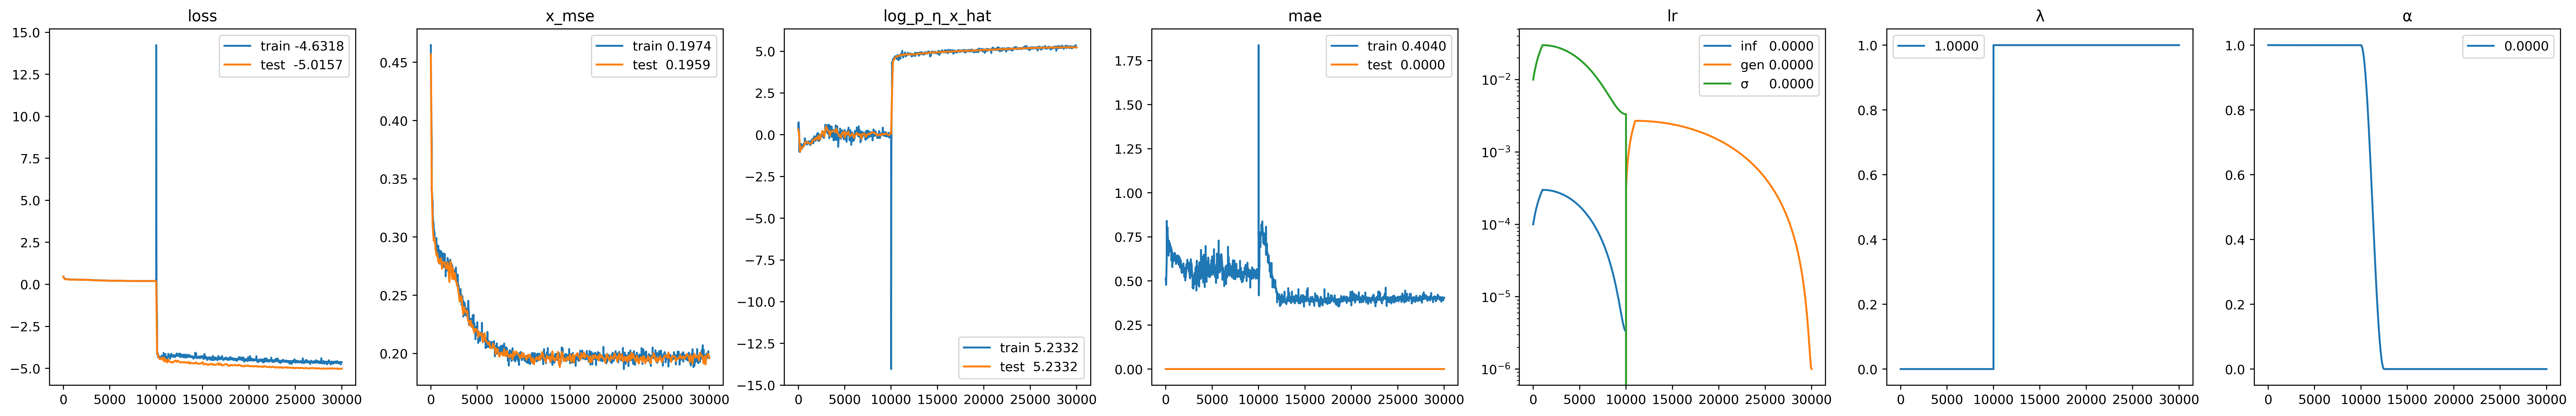

In [18]:
# plot the training history
steps, loss, x_mse, log_p_η_x_hat, mae, λ, α, lr_inference, lr_generative, lr_σ, grad_norm, gen_sum, inf_sum = history.collect(
    "steps", "loss", "x_mse", "log_p_η_x_hat", "mae", "λ", "α", "lr_inference", "lr_generative", "lr_σ", "grad_norm", "gen_sum", "inf_sum"
)
steps_test, loss_test, x_mse_test, log_p_η_x_hat_test, mae_test = history.collect(
    "steps", "loss_test", "x_mse_test", "log_p_η_x_hat", "mae_test"
)

n_plots = 7
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")
# axs[0].set_yscale("symlog")

axs[1].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[1].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("x_mse")

axs[2].plot(steps, log_p_η_x_hat, label=f"train {log_p_η_x_hat[-1]:.4f}")
axs[2].plot(steps_test, log_p_η_x_hat_test, label=f"test  {log_p_η_x_hat_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("log_p_η_x_hat")

axs[3].plot(steps, mae, label=f"train {mae[-1]:.4f}")
axs[3].plot(steps_test, mae_test, label=f"test  {mae_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("mae")

axs[4].plot(steps, lr_inference, label=f"inf   {lr_inference[-1]:.4f}")
axs[4].plot(steps, lr_generative, label=f"gen {lr_generative[-1]:.4f}")
axs[4].plot(steps, lr_σ, label=f"σ     {lr_σ[-1]:.4f}")
axs[4].legend()
axs[4].set_title("lr")
axs[4].set_yscale("log")

axs[5].plot(steps, λ, label=f"{λ[-1]:.4f}")
axs[5].legend()
axs[5].set_title("λ")

axs[6].plot(steps, α, label=f"{α[-1]:.4f}")
axs[6].legend()
axs[6].set_title("α")

# axs[5].plot(steps, gen_sum, label=f"gen {gen_sum[-1]:.4f}")
# axs[5].plot(steps, inf_sum, label=f"inf   {inf_sum[-1]:.4f}")
# axs[5].legend()
# axs[5].set_title("grad_sum")

plt.show()

In [19]:
# load the best model using flax checkpointing
from flax.training import checkpoints

# best_state = checkpoints.restore_checkpoint(ckpt_dir='checkpoint', target=state)
# best_state.step

In [20]:
jax.nn.softplus(final_state.params['inference_net']['σ_']).mean()

Array(8.783276e-05, dtype=float32)

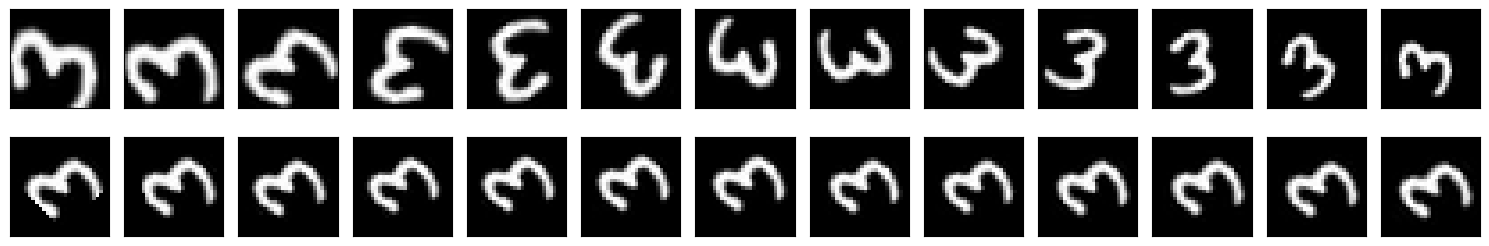

In [21]:
from src.utils.plotting import rescale_for_imshow

val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

x_ = val_batch['image'][0][14]

def get_proto(x):
    η, _ = final_state.apply_fn({"params": final_state.avg_params if final_state.avg_params is not None else final_state.params},
                            x, train=False, rngs={"sample": rng})
    xhat = transform_image(x, -η)
    return xhat, η

for mask in [
    # jnp.array([0, 0, 1, 0, 0]),
    # jnp.array([1, 1, 0, 0, 0]),
    # jnp.array([0, 0, 0, 1, 1]),
    jnp.array([1, 1, 1, 1, 1])
]:

    transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
        x_,
        jnp.linspace(-jnp.array(config.model.bounds) * mask, jnp.array(config.model.bounds) * mask, 13)
    )

    xhats, ηs = jax.vmap(get_proto)(transformed_xs)

    fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

    for ax, x in zip(axs[0], list(transformed_xs)):
        ax.imshow(rescale_for_imshow(x), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, xhat in zip(axs[1], list(xhats)):
        ax.imshow(rescale_for_imshow(xhat), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [22]:
from scipy.stats import gaussian_kde

p_H_X_hat, p_H_X_hat_vars = model.bind({"params": final_state.params}).generative_net.unbind()
q_H_X, q_H_X_vars = model.bind({"params": final_state.params}).inference_net.unbind()

# function to plot the histograms of p(η|x_hat) in each dimmension
def plot_hists(x, n=10_000):
    q_H_x = q_H_X.apply(q_H_X_vars, x)
    ηs_q, log_probs = q_H_x.sample_and_log_prob(seed=random.PRNGKey(0), sample_shape=(n))
    η = ηs_q[jnp.argmax(log_probs)]
    xhat = transform_image(x, -η)

    p_H_x_hat = p_H_X_hat.apply(p_H_X_hat_vars, xhat)
    
    ηs_p = p_H_x_hat.sample(seed=random.PRNGKey(0), sample_shape=(10_000,))

    D = p_H_x_hat.event_shape[0]
    fig, axs = plt.subplots(1, D + 2, figsize=(3*(D+2), 3))

    axs[0].imshow(rescale_for_imshow(x), cmap='gray')
    axs[1].imshow(rescale_for_imshow(xhat), cmap='gray')

    for i, ax in enumerate(axs[2:]):
        x = np.linspace(config.model.bounds[i], -config.model.bounds[i], 1000)

        # plot p(η|x_hat)
        ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
        kde = gaussian_kde(ηs_p[:, i])
        ax.plot(x, kde(x), color="C0")

        # make a axvline to plot η, make the line dashed
        ax.axvline(η[i], color="C1", linestyle="--")
        # make a twin axis to plot q(η|x)
        ax2 = ax.twinx()
        ax2.hist(ηs_q[:, i], bins=100, density=True, alpha=0.5, color="C1")
        kde = gaussian_kde(ηs_q[:, i])
        ax2.plot(x, kde(x), color="C1")

        ax.set_title(f"dim {i}")
        ax.set_xlim(-config.model.bounds[i], config.model.bounds[i])

    plt.tight_layout()
    plt.show()

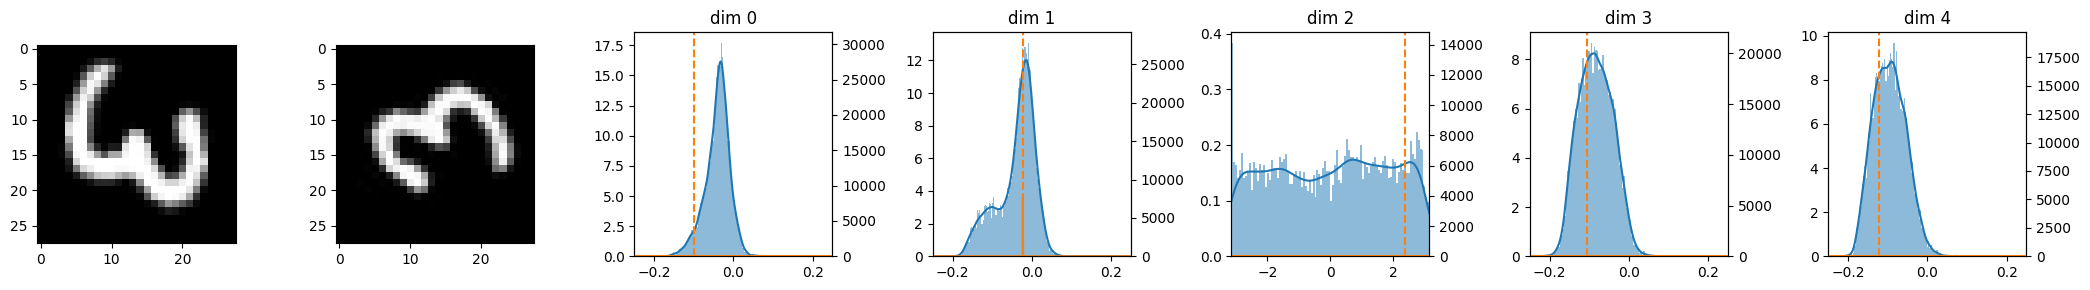

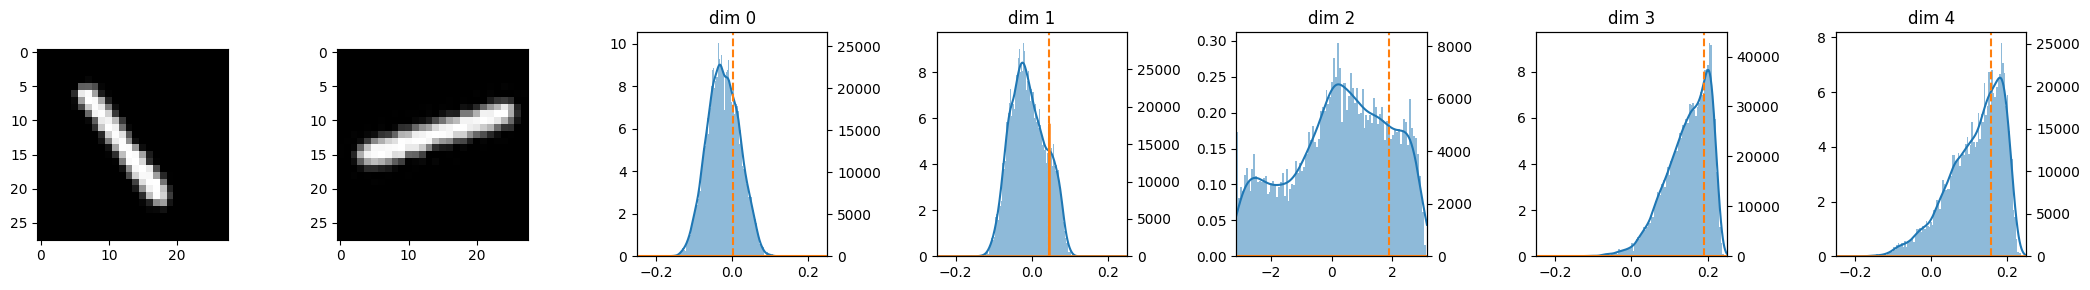

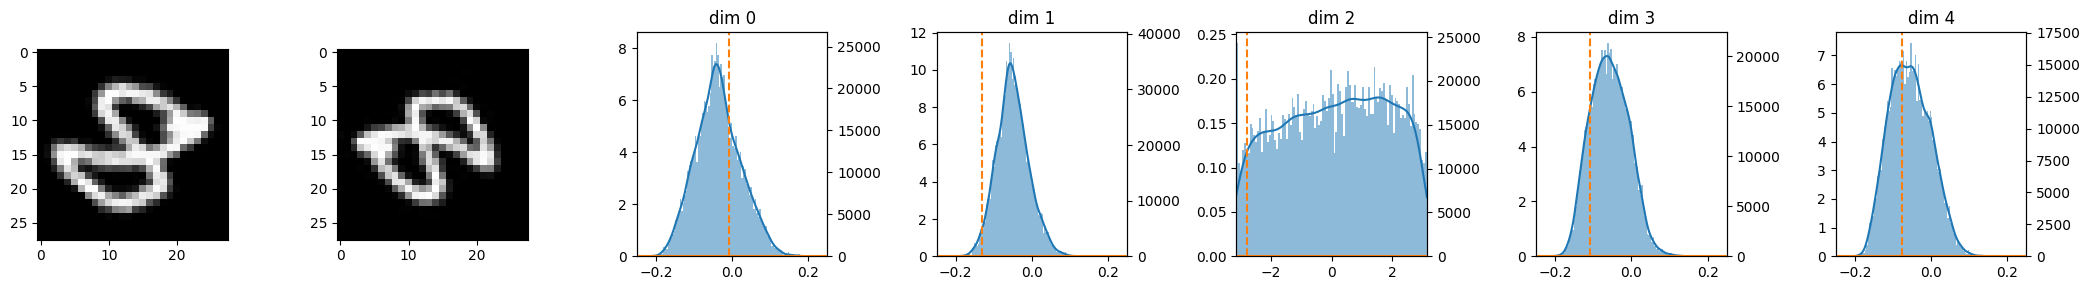

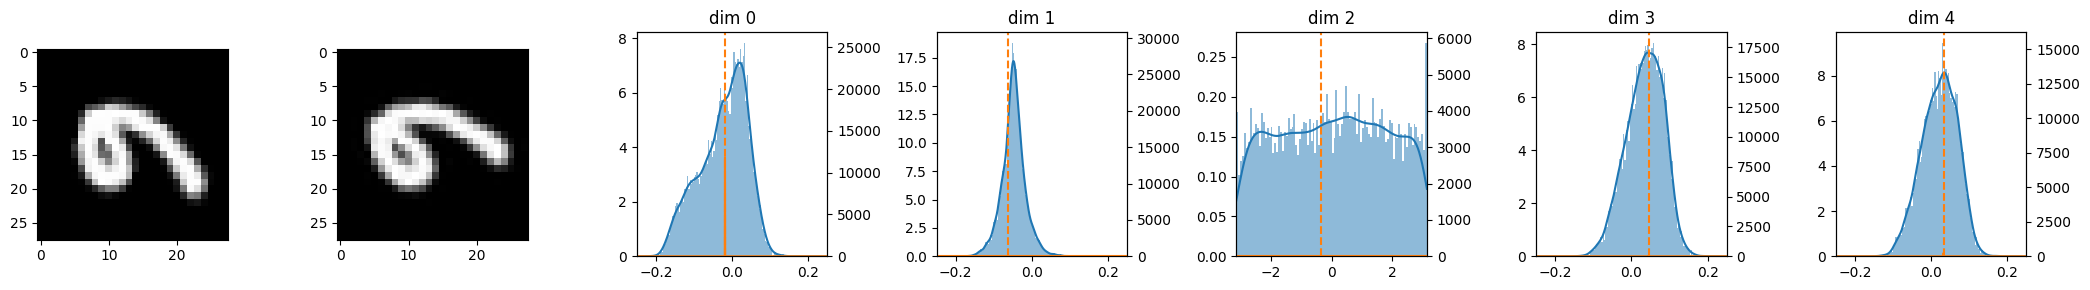

In [23]:
plot_hists(val_batch['image'][0][14], n=1_000)
plot_hists(val_batch['image'][0][1], n=1_000)
plot_hists(val_batch['image'][0][4], n=1_000)
plot_hists(val_batch['image'][0][9], n=1_000)

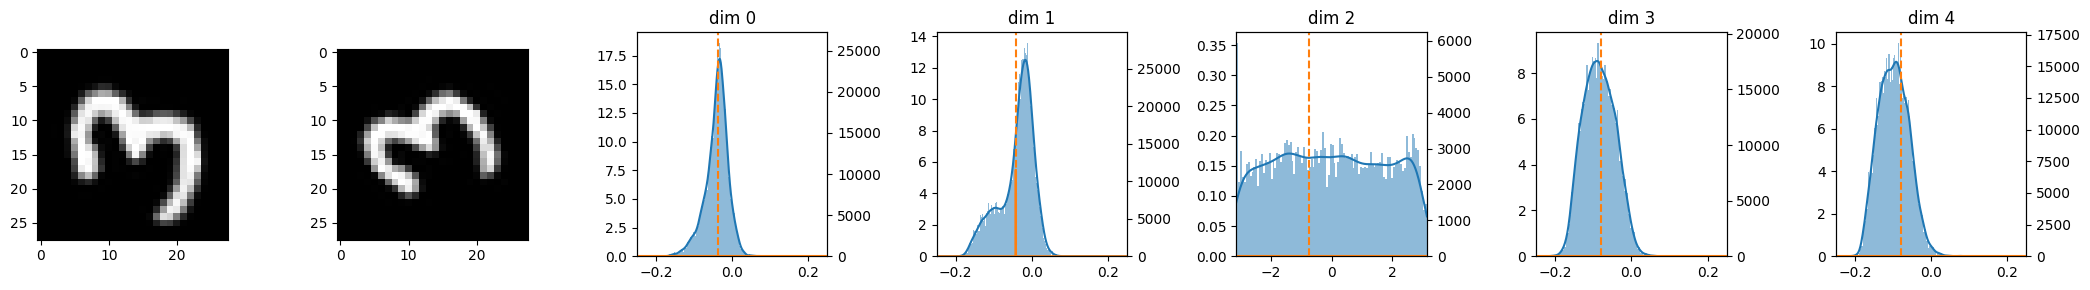

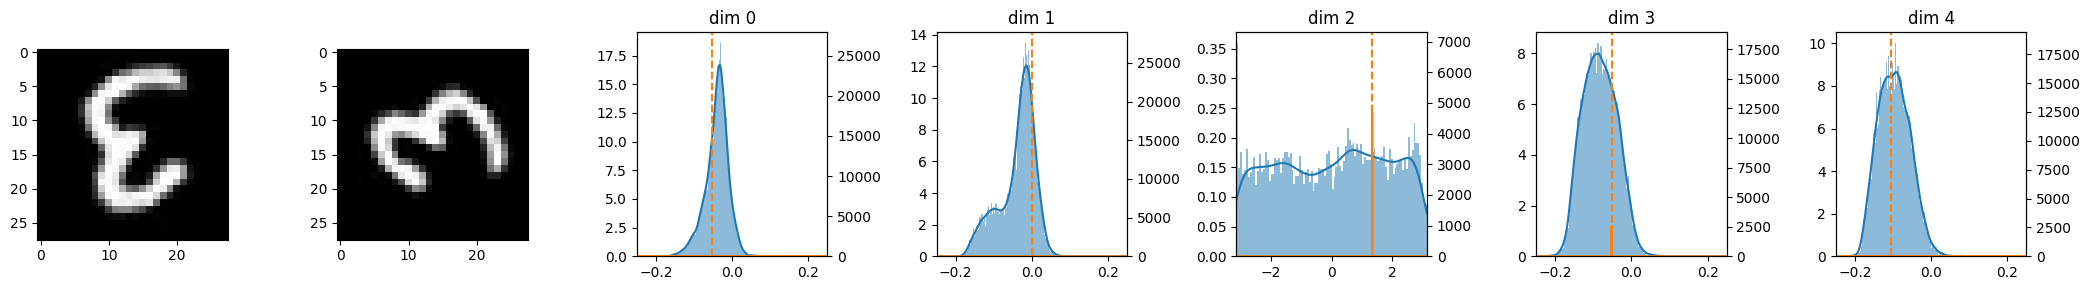

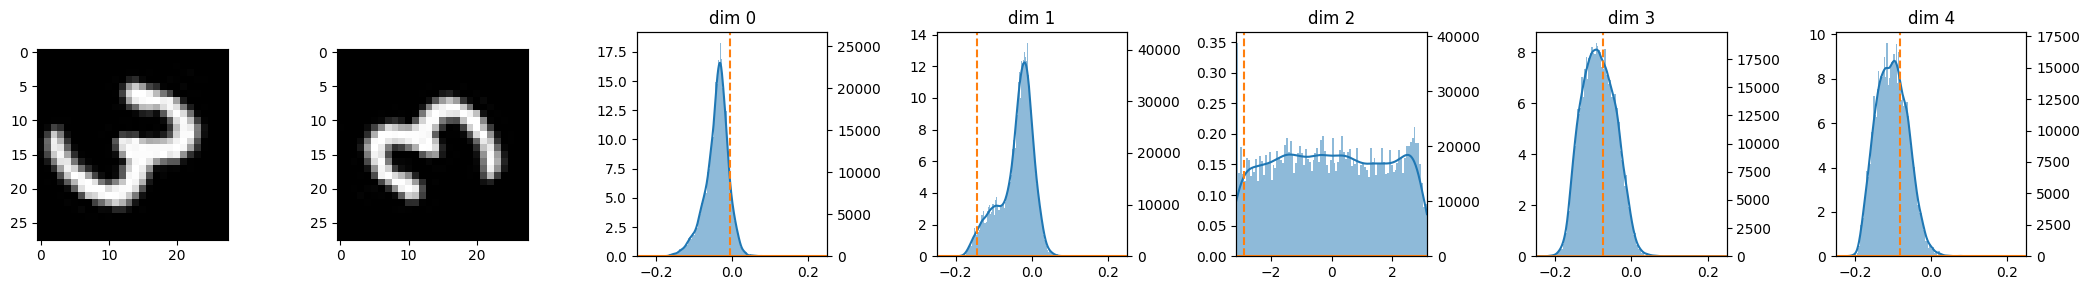

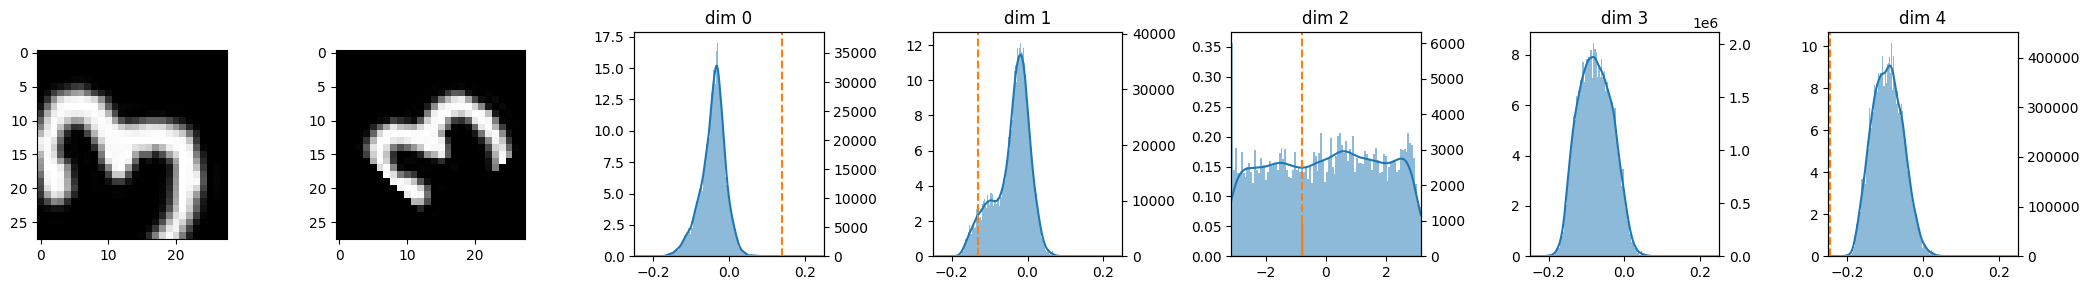

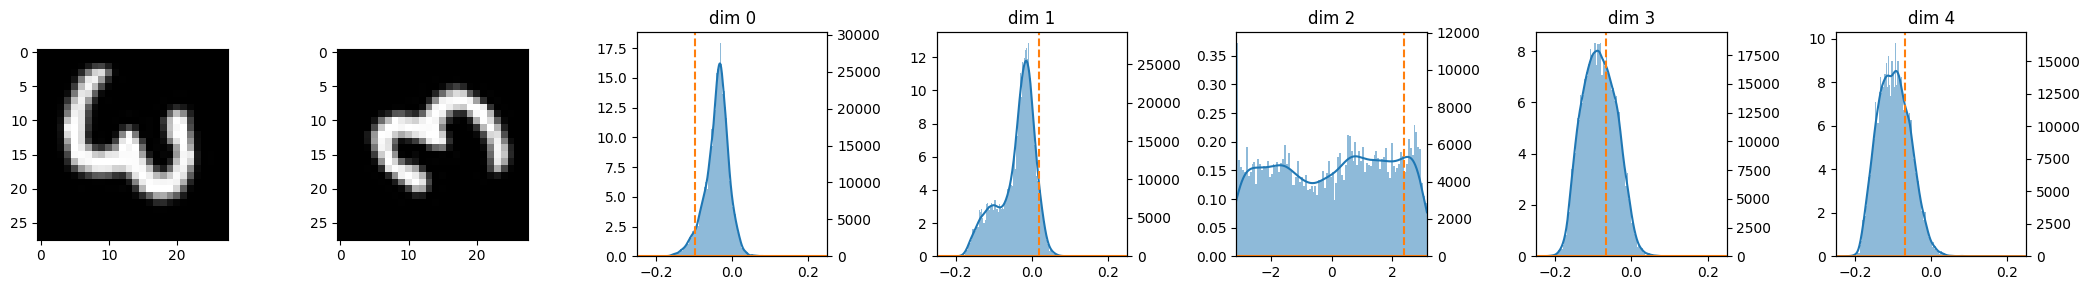

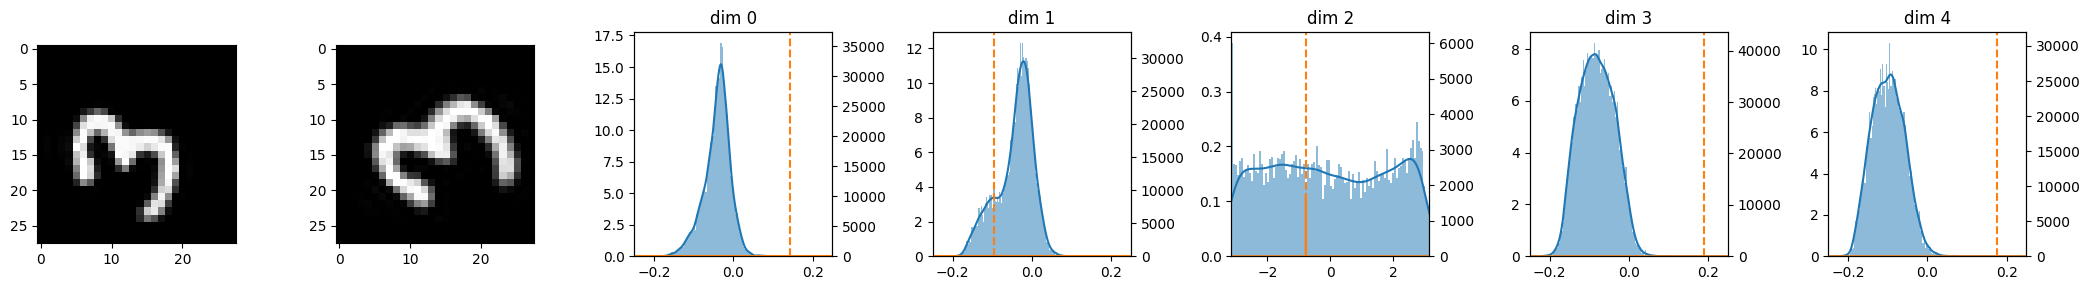

In [24]:
full_mask = jnp.array([1, 1, 1, 1, 1])
rot_mask = jnp.array([0, 0, 1, 0, 0])
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x_,
    jnp.concatenate((
        jnp.linspace(-jnp.array(config.model.bounds) * rot_mask, jnp.array(config.model.bounds) * rot_mask, 4)[:3],
        jnp.linspace(-jnp.array(config.model.bounds) * full_mask, jnp.array(config.model.bounds) * full_mask, 3),
    ))
)

for x in transformed_xs:
    plot_hists(x, n=1_000)

[]

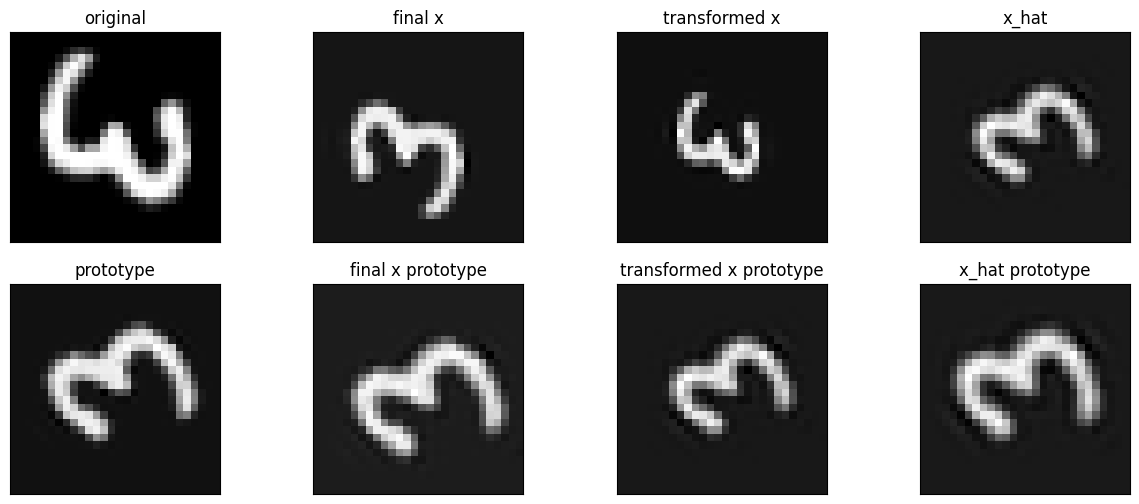

In [25]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(config.model.bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
